In [1]:
import matplotlib.pyplot as plt
import hipercam as hcam
import numpy as np
from astropy import time, coordinates as coord, units as u
from astropy.coordinates import EarthLocation, AltAz

In [2]:
#funcs
def y_to_flux(y,ye,te):
    flux = y/(te*86400)
    flux_err = ye/(te*86400)
    flux_std_err = np.mean(flux_err) / np.sqrt(len(flux_err))
    return flux , flux_err , flux_std_err


def flux_to_mag(flux, error):
    mag = -1 * 2.5*np.log10(flux)
    mag_err = (2.5 / np.log(10)) * (error/flux)
    return mag, mag_err


def mag_to_flux(mag):
    flux = 10**(-0.4 * mag)
    return flux


#def magAB_to_flux(mag, ):
  #  ABflux = 10**(-0.4 * (mag-8.90))
    #ABflux_err = mag_err * (np.log(10) / 2.5) * ABflux
   # return ABflux
def magAB_to_flux(mag):
    ABflux = 10**(-0.4 * (mag-8.90))
    #ABflux_err = mag_err * (np.log(10) / 2.5) * ABflux
    return ABflux

def flux_to_ABmag(flux):
    ABmag = -2.5 * np.log10(flux) + 8.90
    #ABmagErr = (flux_err/flux) * (2.5 / np.log(10))
    return ABmag


def airmass(target_coords,times):
    """
    Returns target airmass given an array of astropy times and the target position.
    """

    frame = AltAz(obstime=times, location=tel_location)
    altazs = target_coords.transform_to(frame)
    airmasses = altazs.secz
    return airmasses
def calculate_phase(bmjd,reference_epoch,period):
    
    phase = ((bmjd - reference_epoch) / period) % 1
    # Shift phases near 1 to negative values
    return np.where(phase < 0.9, phase, phase - 1)




reference_epoch =55641.43601610334
period = 0.24613528148209396


In [3]:
scipath =r'/home/pha19jgb/Science_Runs/2024_06_14/FluxCal/act/run0020.log'

sci_date = scipath.split('/')[-2]

scilog = hcam.hlog.Hlog.rascii(scipath)
tel_location = EarthLocation.of_site('Roque de los Muchachos, La Palma')
obj = coord.SkyCoord("17:17:17.0","+67:57:04",unit=(u.hourangle, u.deg), frame='icrs')

In [4]:
#Extracting the infomation from the log as a time series, ("CCD","Aperture")

sci_u = scilog.tseries("1","1")
sci_g = scilog.tseries("2","1")
sci_r = scilog.tseries("3","1")
sci_i = scilog.tseries("4","1")
sci_z = scilog.tseries("5","1")

In [5]:
#Extracing the same infomation but for the COMPO star

comp_u = scilog.tseries("1","2")
#comp_u = scilog.tseries('1','3') + scilog.tseries('1','3')


comp_g = scilog.tseries("2","3") + scilog.tseries('2','4') 
#comp_g = scilog.tseries("1","2")
ind_g1 = scilog.tseries("2","3")
ind_g2 = scilog.tseries("2","4")

comp_r = scilog.tseries("3","3") + scilog.tseries('3','4')
#comp_r = scilog.tseries("1","2")
ind_r1 = scilog.tseries("3","3")
ind_r2 = scilog.tseries("3","4")

comp_i = scilog.tseries("4","3") + scilog.tseries('4','4')
#comp_i = scilog.tseries("1","2")
ind_i1 = scilog.tseries("4","3")
ind_i2 = scilog.tseries("4","4")


comp_z = scilog.tseries("5","3") +  scilog.tseries('5','4')
#comp_z = scilog.tseries("1","2")
ind_z1 = scilog.tseries("5","3")
ind_z2 = scilog.tseries("5","4")



In [6]:
#Reading the middle time of exposures from pings to a GPS satellite in MJD+UTC, needs to have barycentric corrections performed as the earth moves 

obstime_u_t = time.Time(sci_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_t = time.Time(sci_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_t = time.Time(sci_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_t = time.Time(sci_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_t = time.Time(sci_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

#Now with COMPO

obstime_u_c = time.Time(comp_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_c = time.Time(comp_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_c = time.Time(comp_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_c = time.Time(comp_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_c = time.Time(comp_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

In [7]:
#Barycentric (Solar System (double check) COM) correction built into astropy.Time

barydelta_u_t = obstime_u_t.light_travel_time(obj)
barydelta_g_t = obstime_g_t.light_travel_time(obj)
barydelta_r_t = obstime_r_t.light_travel_time(obj) 
barydelta_i_t = obstime_i_t.light_travel_time(obj) 
barydelta_z_t = obstime_z_t.light_travel_time(obj) 

#now with COMPO

barydelta_u_c = obstime_u_c.light_travel_time(obj)
barydelta_g_c = obstime_g_c.light_travel_time(obj)
barydelta_r_c = obstime_r_c.light_travel_time(obj) 
barydelta_i_c = obstime_i_c.light_travel_time(obj) 
barydelta_z_c = obstime_z_c.light_travel_time(obj) 

In [8]:
#Applying Barycentric correction

baryobs_u_t = (obstime_u_t.tdb + barydelta_u_t).value
baryobs_g_t = (obstime_g_t.tdb + barydelta_g_t).value
baryobs_r_t = (obstime_r_t.tdb + barydelta_r_t).value
baryobs_i_t = (obstime_i_t.tdb + barydelta_i_t).value
baryobs_z_t = (obstime_z_t.tdb + barydelta_z_t).value

#now with COMPO

baryobs_u_c = (obstime_u_c.tdb + barydelta_u_c).value
baryobs_g_c = (obstime_g_c.tdb + barydelta_g_c).value
baryobs_r_c = (obstime_r_c.tdb + barydelta_r_c).value
baryobs_i_c = (obstime_i_c.tdb + barydelta_i_c).value
baryobs_z_c = (obstime_z_c.tdb + barydelta_z_c).value

In [9]:
ratio_u = np.array(sci_u.y / comp_u.y)
ratio_g = np.array(sci_g.y / comp_g.y)
ratio_r = np.array(sci_r.y / comp_r.y)
ratio_i = np.array(sci_i.y / comp_i.y)
ratio_z = np.array(sci_z.y / comp_z.y)

In [10]:
#now to transfer into magnitudes for the science target, #assuming .y is flux

#Sci Targ
sci_flux_u , sci_flux_u_err, sci_flux_u_std_err  = y_to_flux(sci_u.y , sci_u.ye, sci_u.te)
sci_flux_g , sci_flux_g_err, sci_flux_g_std_err  = y_to_flux(sci_g.y , sci_g.ye, sci_g.te)
sci_flux_r , sci_flux_r_err, sci_flux_r_std_err  = y_to_flux(sci_r.y , sci_r.ye, sci_r.te)
sci_flux_i , sci_flux_i_err, sci_flux_i_std_err  = y_to_flux(sci_i.y , sci_i.ye, sci_i.te)
sci_flux_z , sci_flux_z_err, sci_flux_z_std_err  = y_to_flux(sci_z.y , sci_z.ye, sci_z.te)

sci_mag_u , sci_mag_u_err = flux_to_mag(sci_flux_u,sci_flux_u_err)
sci_mag_g , sci_mag_g_err = flux_to_mag(sci_flux_g,sci_flux_g_err)
sci_mag_r , sci_mag_r_err = flux_to_mag(sci_flux_r,sci_flux_r_err)
sci_mag_i , sci_mag_i_err = flux_to_mag(sci_flux_i,sci_flux_i_err)
sci_mag_z , sci_mag_z_err = flux_to_mag(sci_flux_z,sci_flux_z_err)

#Sci Comp
comp_flux_u , comp_flux_u_err, comp_flux_u_std_err = y_to_flux(comp_u.y,comp_u.ye,comp_u.te)
comp_flux_g , comp_flux_g_err, comp_flux_g_std_err = y_to_flux(comp_g.y,comp_g.ye,comp_g.te)
comp_flux_r , comp_flux_r_err, comp_flux_r_std_err = y_to_flux(comp_r.y,comp_r.ye,comp_r.te)
comp_flux_i , comp_flux_i_err, comp_flux_i_std_err = y_to_flux(comp_i.y,comp_i.ye,comp_i.te)
comp_flux_z , comp_flux_z_err, comp_flux_z_std_err = y_to_flux(comp_z.y,comp_z.ye,comp_z.te)

comp_mag_u , comp_mag_u_err = flux_to_mag(comp_flux_u,comp_flux_u_err)
comp_mag_g , comp_mag_g_err = flux_to_mag(comp_flux_g,comp_flux_g_err)
comp_mag_r , comp_mag_r_err = flux_to_mag(comp_flux_r,comp_flux_r_err)
comp_mag_i , comp_mag_i_err = flux_to_mag(comp_flux_i,comp_flux_i_err)
comp_mag_z , comp_mag_z_err = flux_to_mag(comp_flux_z,comp_flux_z_err)

#also need Sci Airmasses
sci_airm_u = airmass(obj,obstime_u_t)
sci_airm_g = airmass(obj,obstime_g_t)
sci_airm_r = airmass(obj,obstime_r_t)
sci_airm_i = airmass(obj,obstime_i_t)
sci_airm_z = airmass(obj,obstime_z_t)


comp_airm_u = airmass(obj,obstime_u_c)
comp_airm_g = airmass(obj,obstime_g_c)
comp_airm_r = airmass(obj,obstime_r_c)
comp_airm_i = airmass(obj,obstime_i_c)
comp_airm_z = airmass(obj,obstime_z_c)

In [11]:
#trying to get the specific values for the flux calibrations
#g bands first
ind1_flux_g , ind1_flux_g_err , ind1_flux_g_std = y_to_flux(ind_g1.y, ind_g1.ye, ind_g1.te) # counts to flux
ind2_flux_g , ind2_flux_g_err , ind2_flux_g_std = y_to_flux(ind_g2.y,ind_g2.ye,ind_g2.te)



ind1_mag_g , ind1_mag_g_err = flux_to_mag(ind1_flux_g,ind1_flux_g_err) # flux to mag
ind2_mag_g , ind2_mag_g_err = flux_to_mag(ind2_flux_g,ind2_flux_g_err)

#r bands
ind1_flux_r , ind1_flux_r_err , ind1_flux_r_err = y_to_flux(ind_r1.y,ind_r1.ye,ind_r1.te) # counts to flux
ind2_flux_r , ind2_flux_r_err , ind2_flux_r_err = y_to_flux(ind_r2.y,ind_r2.ye,ind_r2.te)

ind1_mag_r , ind1_mag_r_err = flux_to_mag(ind1_flux_r,ind1_flux_r_err) # flux to mag
ind2_mag_r , ind2_mag_r_err = flux_to_mag(ind2_flux_r,ind2_flux_r_err)

#i
ind1_flux_i , ind1_flux_i_err , ind1_flux_i_err = y_to_flux(ind_i1.y,ind_i1.ye,ind_i1.te)# counts to flux
ind2_flux_i , ind2_flux_i_err , ind2_flux_i_err = y_to_flux(ind_i2.y,ind_i2.ye,ind_i2.te)

ind1_mag_i , ind1_mag_i_err = flux_to_mag(ind1_flux_i,ind1_flux_i_err) # flux to mag
ind2_mag_i , ind2_mag_i_err = flux_to_mag(ind2_flux_i,ind2_flux_i_err)

#z
ind1_flux_z , ind1_flux_z_err , ind1_flux_z_err = y_to_flux(ind_z1.y,ind_z1.ye,ind_z1.te)# counts to flux
ind2_flux_z , ind2_flux_z_err , ind2_flux_z_err = y_to_flux(ind_z2.y,ind_z2.ye,ind_z2.te)

ind1_mag_z , ind1_mag_z_err = flux_to_mag(ind1_flux_z,ind1_flux_z_err) # flux to mag
ind2_mag_z , ind2_mag_z_err = flux_to_mag(ind2_flux_z,ind2_flux_z_err)

#testing airmasses:
obstime_ind1_g = time.Time(ind_g1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1g = obstime_ind1_g.light_travel_time(obj)
baryobs_ind1g = (obstime_ind1_g.tdb + barydelta_ind1g).value
ind1_airm_g = airmass(obj,obstime_ind1_g)

obstime_ind2_g = time.Time(ind_g2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2g = obstime_ind2_g.light_travel_time(obj)
baryobs_ind2g = (obstime_ind2_g.tdb + barydelta_ind1g).value
ind2_airm_g = airmass(obj,obstime_ind2_g)

obstime_ind1_r = time.Time(ind_r1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1r = obstime_ind1_r.light_travel_time(obj)
baryobs_ind1r = (obstime_ind1_r.tdb + barydelta_ind1r).value
ind1_airm_r = airmass(obj,obstime_ind1_r)

obstime_ind2_r = time.Time(ind_r2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2r = obstime_ind2_r.light_travel_time(obj)
baryobs_ind2r = (obstime_ind2_r.tdb + barydelta_ind1r).value
ind2_airm_r = airmass(obj,obstime_ind2_r)

obstime_ind1_i = time.Time(ind_i1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1i = obstime_ind1_i.light_travel_time(obj)
baryobs_ind1i = (obstime_ind1_i.tdb + barydelta_ind1i).value
ind1_airm_i = airmass(obj,obstime_ind1_i)

obstime_ind2_i = time.Time(ind_i2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2i = obstime_ind2_i.light_travel_time(obj)
baryobs_ind2i = (obstime_ind2_i.tdb + barydelta_ind1i).value
ind2_airm_i = airmass(obj,obstime_ind2_i)

obstime_ind1_z = time.Time(ind_z1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1z = obstime_ind1_z.light_travel_time(obj)
baryobs_ind1z = (obstime_ind1_z.tdb + barydelta_ind1z).value
ind1_airm_z = airmass(obj,obstime_ind1_z)

obstime_ind2_z = time.Time(ind_z2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2z = obstime_ind2_z.light_travel_time(obj)
baryobs_ind2z = (obstime_ind2_z.tdb + barydelta_ind1z).value
ind2_airm_z = airmass(obj,obstime_ind2_z)

In [12]:
extpath =r'/home/pha19jgb/Science_Runs/2024_06_14/FluxCal/act/edit5.log'
#extpath =r'/home/pha19jgb/Science_Runs/2024_04_30/FluxCal/12.11/airm18_test.log'
ext_date = extpath.split('/')[-2]

extlog = hcam.hlog.Hlog.rascii(extpath)
tel_location = EarthLocation.of_site('Roque de los Muchachos, La Palma')
#ext = coord.SkyCoord("18:28:47.0","+23:07:32",unit=(u.hourangle, u.deg), frame='icrs') #run14
#ext = coord.SkyCoord("21:16:03.0","+24:45:52",unit=(u.hourangle, u.deg), frame='icrs') #run18
ext = obj


In [13]:
airm_u = extlog.tseries("1","4") 
airm_g = extlog.tseries("2","4") 
airm_r = extlog.tseries("3","4")
airm_i = extlog.tseries("4","4")
airm_z = extlog.tseries("5","4")

obstime_u_airm = time.Time(airm_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_airm = time.Time(airm_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_airm = time.Time(airm_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_airm = time.Time(airm_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_airm = time.Time(airm_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

barydelta_u_airm = obstime_u_airm.light_travel_time(ext)
barydelta_g_airm = obstime_g_airm.light_travel_time(ext)
barydelta_r_airm = obstime_r_airm.light_travel_time(ext) 
barydelta_i_airm = obstime_i_airm.light_travel_time(ext) 
barydelta_z_airm = obstime_z_airm.light_travel_time(ext)

baryobs_u_airm = (obstime_u_airm.tdb + barydelta_u_airm).value
baryobs_g_airm = (obstime_g_airm.tdb + barydelta_g_airm).value
baryobs_r_airm = (obstime_r_airm.tdb + barydelta_r_airm).value
baryobs_i_airm = (obstime_i_airm.tdb + barydelta_i_airm).value
baryobs_z_airm = (obstime_z_airm.tdb + barydelta_z_airm).value

airm_flux_u , airm_flux_u_err, airm_flux_u_std_err  = y_to_flux(airm_u.y , airm_u.ye, airm_u.te)
airm_flux_g , airm_flux_g_err, airm_flux_g_std_err  = y_to_flux(airm_g.y , airm_g.ye, airm_g.te)
airm_flux_r , airm_flux_r_err, airm_flux_r_std_err  = y_to_flux(airm_r.y , airm_r.ye, airm_r.te)
airm_flux_i , airm_flux_i_err, airm_flux_i_std_err  = y_to_flux(airm_i.y , airm_i.ye, airm_i.te)
airm_flux_z , airm_flux_z_err, airm_flux_z_std_err  = y_to_flux(airm_z.y , airm_z.ye, airm_z.te)

airm_mag_u , airm_mag_u_err = flux_to_mag(airm_flux_u,airm_flux_u_err)
airm_mag_g , airm_mag_g_err = flux_to_mag(airm_flux_g,airm_flux_g_err)
airm_mag_r , airm_mag_r_err = flux_to_mag(airm_flux_r,airm_flux_r_err)
airm_mag_i , airm_mag_i_err = flux_to_mag(airm_flux_i,airm_flux_i_err)
airm_mag_z , airm_mag_z_err = flux_to_mag(airm_flux_z,airm_flux_z_err)

airm_am_u = airmass(ext,obstime_u_airm)
airm_am_g = airmass(ext,obstime_g_airm)
airm_am_r = airmass(ext,obstime_r_airm)
airm_am_i = airmass(ext,obstime_i_airm)
airm_am_z = airmass(ext,obstime_z_airm)


y = 0.28x + -10.94
y = 0.14x + -14.70
y = 0.06x + -15.04
y = 0.02x + -14.91
y = 0.02x + -14.73


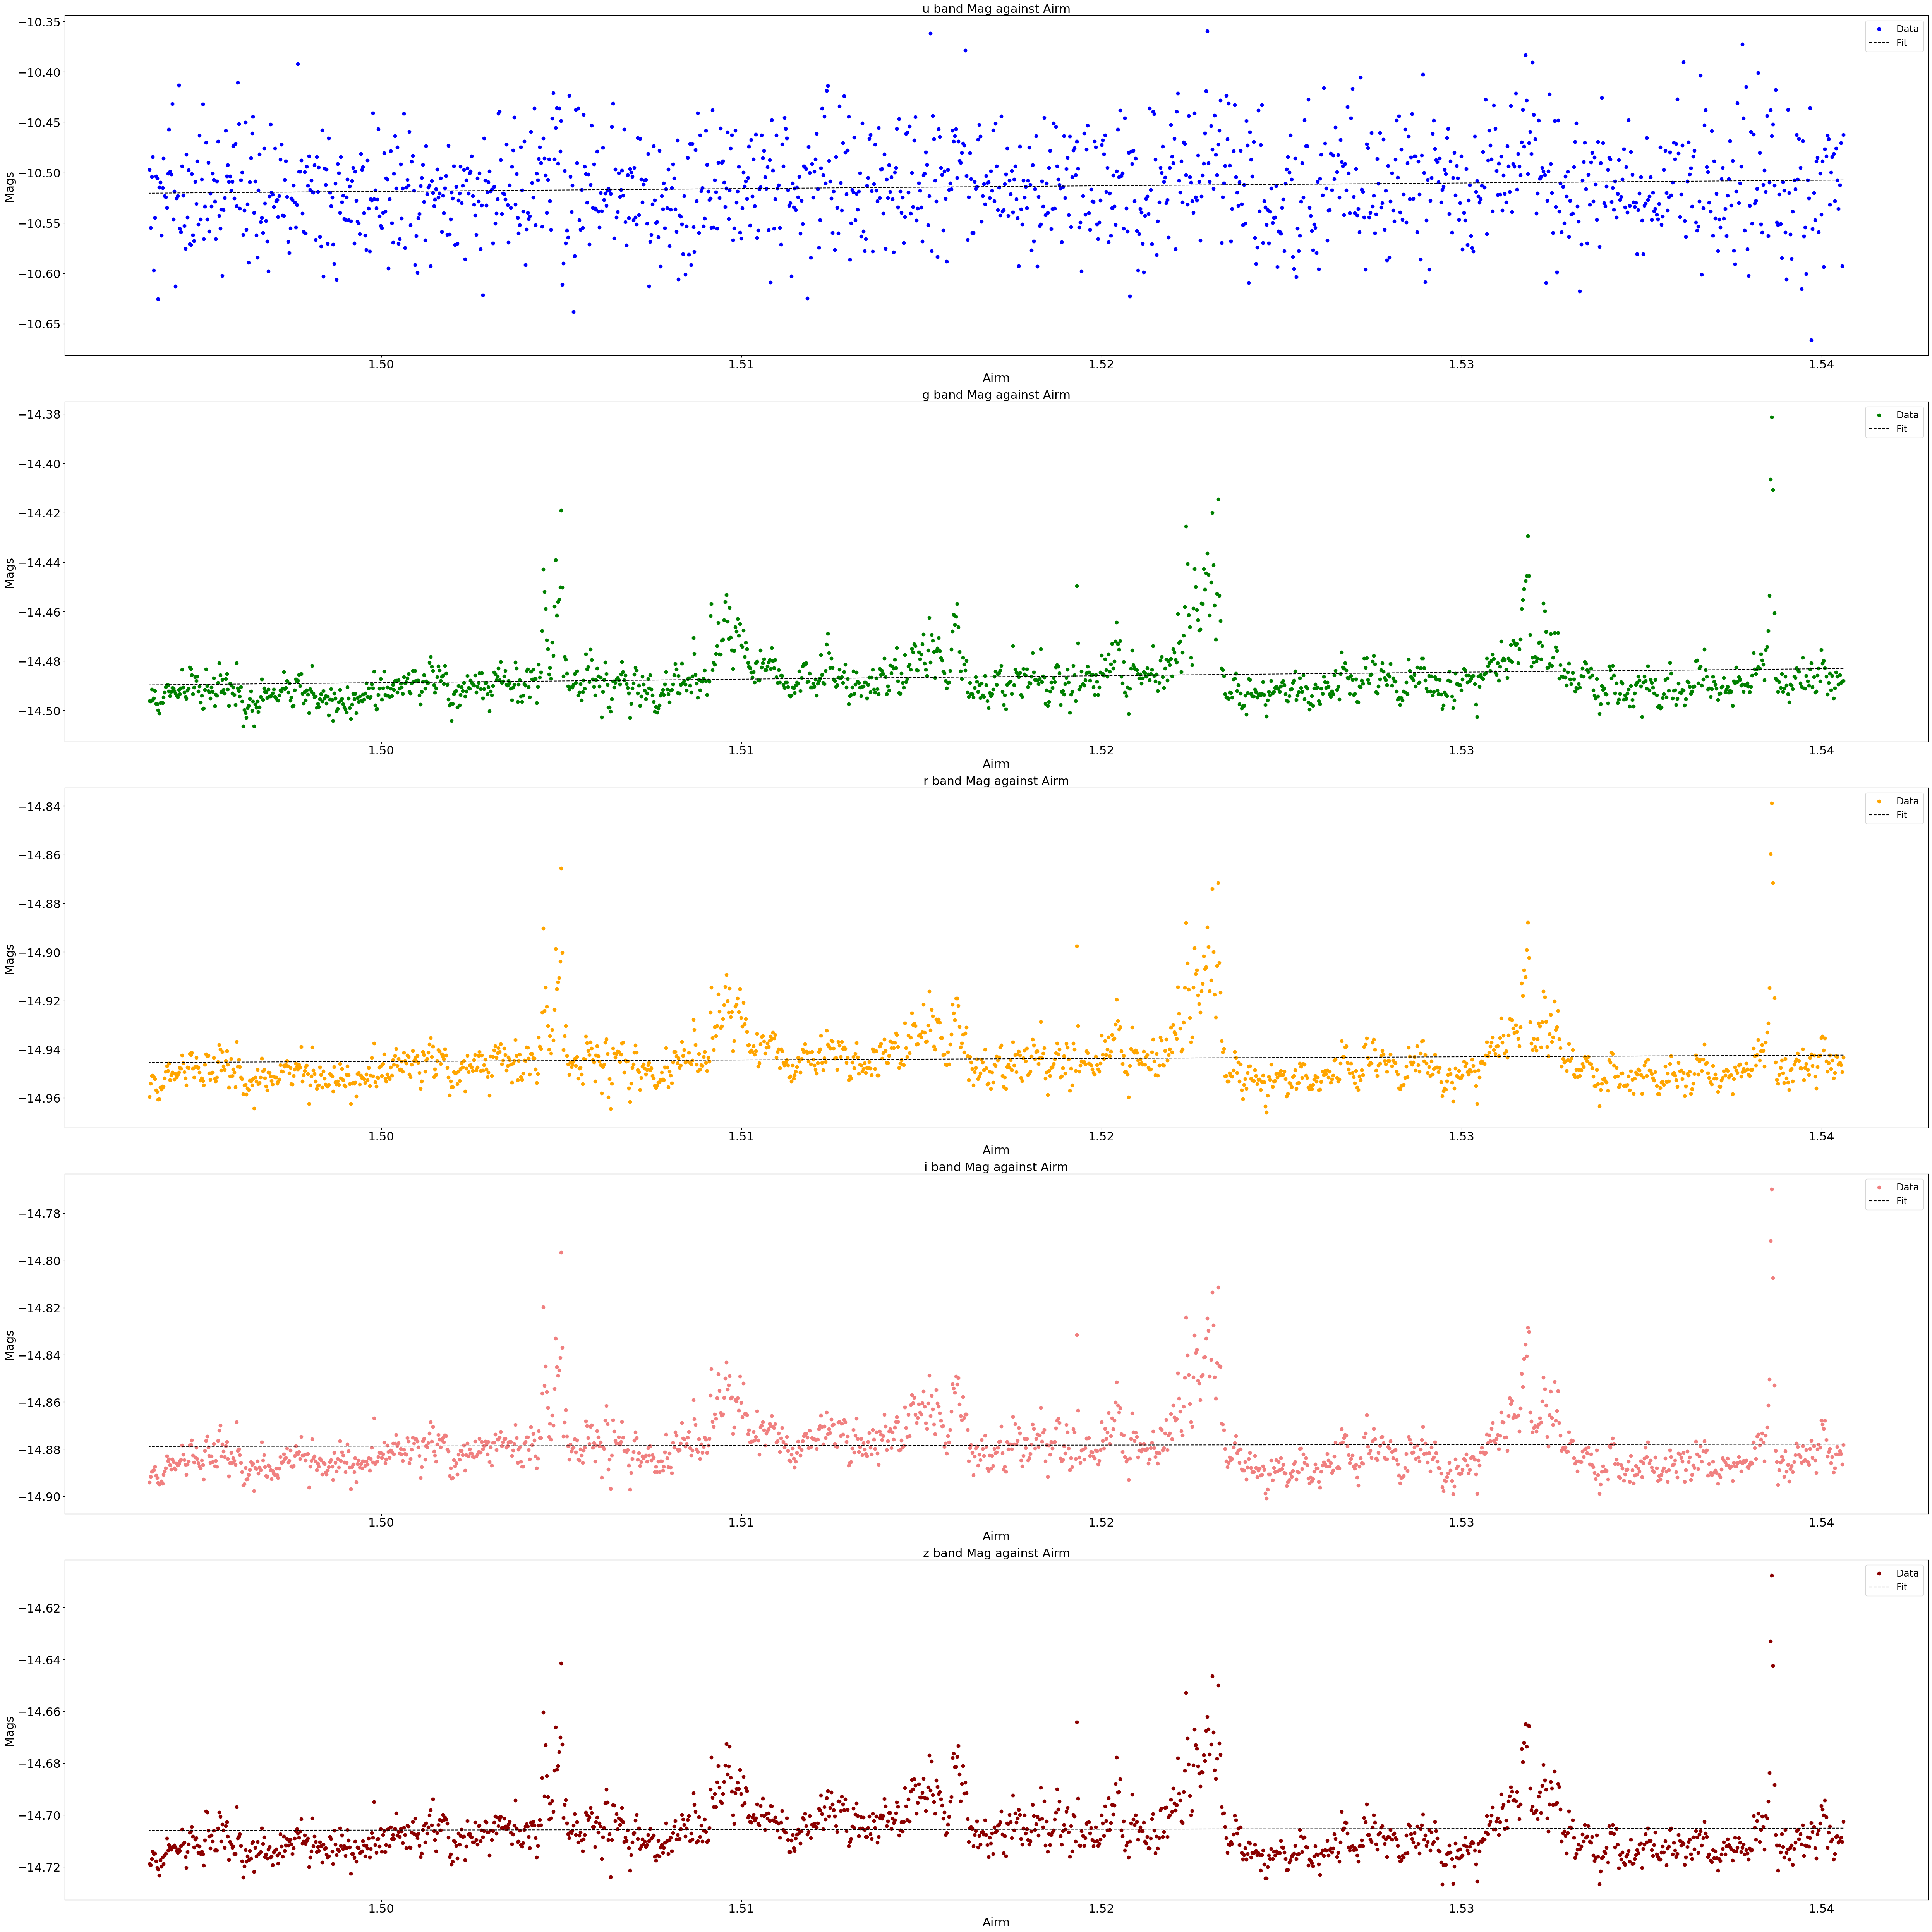

In [14]:
bands = ['u', 'g', 'r', 'i', 'z']
mags = [airm_mag_u,airm_mag_g,airm_mag_r,airm_mag_i,airm_mag_z]
airm = [airm_am_u,airm_am_g,airm_am_r,airm_am_i,airm_am_z]
colours = ['b', 'g', 'orange', 'lightcoral', 'darkred']
kx = []

fig, axs = plt.subplots(nrows=5, figsize=(50,50))  # Adjust figsize as needed


for i, (band, mag, air, colour) in enumerate(zip(bands, mags, airm, colours)):
    # Plot the original data
    axs[i].scatter(air, mag, color=colour, label='Data')

    # Fit a straight line
    coefficients = np.polyfit(air, mag, 1)  # 1 for linear fit
    poly = np.poly1d(coefficients)
    fitted_line = poly(air)
    kx.append(coefficients[0])
    # Plot the fitted line
    axs[i].plot(air, fitted_line, color='black', linestyle='--', label='Fit')

    # Set title and labels
    axs[i].set_title(f"{band.lower()} band Mag against Airm", fontsize=22)
    axs[i].set_xlabel("Airm", fontsize=22)
    axs[i].set_ylabel('Mags', fontsize=22)
    axs[i].tick_params(axis='both', which='major', labelsize=22)
    axs[i].tick_params(axis='both', which='minor', labelsize=22)

    # Add legend
    axs[i].legend(fontsize=18)
    m, c = coefficients
    print(f'y = {m:.2f}x + {c:.2f}')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [15]:
#stdpath = r'/home/pha19jgb/Science_Runs/2024_06_14/FluxCal/act/edit5.log'
stdpath =r'/home/pha19jgb/Science_Runs/2024_04_30/FluxCal/12.11/std_red2.log'
std_date = stdpath.split('/')[-2]

stdlog = hcam.hlog.Hlog.rascii(stdpath)
tel_location = EarthLocation.of_site('Roque de los Muchachos, La Palma')
std = coord.SkyCoord("12:37:26.0","+25:04:22",unit=(u.hourangle, u.deg), frame='icrs')

In [16]:
std_u = stdlog.tseries("1","1")
std_g = stdlog.tseries("2","1")
std_r = stdlog.tseries("3","1")
std_i = stdlog.tseries("4","1")
std_z = stdlog.tseries("5","1")

obstime_u_std = time.Time(std_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_std = time.Time(std_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_std = time.Time(std_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_std = time.Time(std_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_std = time.Time(std_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

barydelta_u_std = obstime_u_std.light_travel_time(std)
barydelta_g_std = obstime_g_std.light_travel_time(std)
barydelta_r_std = obstime_r_std.light_travel_time(std) 
barydelta_i_std = obstime_i_std.light_travel_time(std) 
barydelta_z_std = obstime_z_std.light_travel_time(std)

baryobs_u_std = (obstime_u_std.tdb + barydelta_u_std).value
baryobs_g_std = (obstime_g_std.tdb + barydelta_g_std).value
baryobs_r_std = (obstime_r_std.tdb + barydelta_r_std).value
baryobs_i_std = (obstime_i_std.tdb + barydelta_i_std).value
baryobs_z_std = (obstime_z_std.tdb + barydelta_z_std).value

std_flux_u , std_flux_u_err, std_flux_u_std_err  = y_to_flux(std_u.y , std_u.ye, std_u.te)
std_flux_g , std_flux_g_err, std_flux_g_std_err  = y_to_flux(std_g.y , std_g.ye, std_g.te)
std_flux_r , std_flux_r_err, std_flux_r_std_err  = y_to_flux(std_r.y , std_r.ye, std_r.te)
std_flux_i , std_flux_i_err, std_flux_i_std_err  = y_to_flux(std_i.y , std_i.ye, std_i.te)
std_flux_z , std_flux_z_err, std_flux_z_std_err  = y_to_flux(std_z.y , std_z.ye, std_z.te)

std_mag_u , std_mag_u_err = flux_to_mag(std_flux_u,std_flux_u_err)
std_mag_g , std_mag_g_err = flux_to_mag(std_flux_g,std_flux_g_err)
std_mag_r , std_mag_r_err = flux_to_mag(std_flux_r,std_flux_r_err)
std_mag_i , std_mag_i_err = flux_to_mag(std_flux_i,std_flux_i_err)
std_mag_z , std_mag_z_err = flux_to_mag(std_flux_z,std_flux_z_err)

std_airm_u = airmass(std,obstime_u_std)
std_airm_g = airmass(std,obstime_g_std)
std_airm_r = airmass(std,obstime_r_std)
std_airm_i = airmass(std,obstime_i_std)
std_airm_z = airmass(std,obstime_z_std)

In [17]:
#11.168 11.547 12.059 12.446 12.787
#kx = np.array([0.55 , 0.25, 0.15, 0.09, 0.06])
##mzp = np.array([28.17,29.25,28.76,28.43,27.95])
mzp_u = 11.168 - std_mag_u + kx[0]*std_airm_u #mzp,x = m0,std,x − mi,std,x + kxXstd , 
mzp_g = 11.547 - std_mag_g + kx[1]*std_airm_g
mzp_r = 12.059 - std_mag_r + kx[2]*std_airm_r
mzp_i = 12.446 - std_mag_i +kx[3]*std_airm_i
mzp_z = 12.787 - std_mag_z + kx[4]*std_airm_z
#m0,std,x has come from Brown 2022 Appendix A

mzp_u = np.median(mzp_u)
mzp_g = np.median(mzp_g)
mzp_r = np.median(mzp_r)
mzp_i = np.median(mzp_i)
mzp_z = np.median(mzp_z)

mzp = np.array([mzp_u, mzp_g, mzp_r, mzp_i, mzp_z])

print(mzp)

[28.6698081  30.25403706 29.89296624 29.53523525 29.17202152]


In [18]:
calib_u = sci_mag_u - ( kx[0]*sci_airm_u) + mzp[0] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_u_c = comp_mag_u - ( kx[0]*comp_airm_u) + mzp[0]
fcal_u = magAB_to_flux(calib_u)
fcal_u_c =np.mean( magAB_to_flux(calib_u_c))

calib_g = sci_mag_g - ( kx[1]*sci_airm_g) + mzp[1] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_g_c = comp_mag_g - ( kx[1]*comp_airm_g) + mzp[1]
fcal_g = magAB_to_flux(calib_g)
fcal_g_c = magAB_to_flux(calib_g_c)

calib_r = sci_mag_r - ( kx[2]*sci_airm_r) + mzp[2] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_r_c = comp_mag_r - ( kx[2]*comp_airm_r) + mzp[2]
fcal_r = magAB_to_flux(calib_r)
fcal_r_c = magAB_to_flux(calib_r_c)

calib_i = sci_mag_i - ( kx[3]*sci_airm_i) + mzp[3] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_i_c = comp_mag_i - ( kx[3]*comp_airm_i) + mzp[3]
fcal_i = magAB_to_flux(calib_i)
fcal_i_c = magAB_to_flux(calib_i_c)

calib_z = sci_mag_z - ( kx[4]*sci_airm_z) + mzp[4] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_z_c = comp_mag_z - ( kx[4]*comp_airm_z) + mzp[4]
fcal_z = magAB_to_flux(calib_z)
fcal_z_c = magAB_to_flux(calib_z_c)

In [19]:
#individual comparison star calibrations

calib_ind1_g = ind1_mag_g - ( kx[1]*ind1_airm_g) + mzp[1]
calib_ind2_g = ind2_mag_g - ( kx[1]*ind2_airm_g) + mzp[1]

fcal_ind1_g = magAB_to_flux(calib_ind1_g)
fcal_ind2_g = magAB_to_flux(calib_ind2_g)

fcaltot_g = np.median(fcal_ind1_g + fcal_ind2_g)

calib_ind1_r = ind1_mag_r - ( kx[2]*ind1_airm_r) + mzp[2]
calib_ind2_r = ind2_mag_r - ( kx[2]*ind2_airm_r) + mzp[2]

fcal_ind1_r = magAB_to_flux(calib_ind1_r)
fcal_ind2_r = magAB_to_flux(calib_ind2_r)

fcaltot_r =np.median( fcal_ind1_r + fcal_ind2_r)

calib_ind1_i = ind1_mag_i - ( kx[3]*ind1_airm_i) + mzp[3]
calib_ind2_i = ind2_mag_i - ( kx[3]*ind2_airm_i) + mzp[3]

fcal_ind1_i = magAB_to_flux(calib_ind1_i)
fcal_ind2_i = magAB_to_flux(calib_ind2_i)

fcaltot_i = np.median(fcal_ind1_i + fcal_ind2_i)

calib_ind1_z = ind1_mag_z - ( kx[4]*ind1_airm_z) + mzp[4]
calib_ind2_z = ind2_mag_z - ( kx[4]*ind2_airm_z) + mzp[4]

fcal_ind1_z = magAB_to_flux(calib_ind1_z)
fcal_ind2_z = magAB_to_flux(calib_ind2_z)

fcaltot_z = np.median(fcal_ind1_z + fcal_ind2_z)

In [20]:
#setting the reference epoch and period in order to phase fold the data,

#taking fcaltot from different 04_30
fcal_u_c = 0.012567342320385312
fcaltot_g = 0.012841698996236986
fcaltot_r = 0.02306820396766342
fcaltot_i = 0.02875835235015073
fcaltot_z = 0.031758141795920555


cal_flux_u = ratio_u * fcal_u_c


cal_flux_g = ratio_g * fcaltot_g

cal_flux_r = ratio_r * fcaltot_r

cal_flux_i = ratio_i * fcaltot_i

cal_flux_z = ratio_z * fcaltot_z
#diffFluxErr = ((t_ye / t_y)**2 + (c_ye / c_y)**2)**0.5 * np.abs(diffFlux)
diffFluxErr_u = ((sci_u.ye / sci_u.y)**2 + (comp_u.ye / comp_u.y)**2)**0.5 * np.abs(cal_flux_u)

diffFluxErr_g = ((sci_g.ye / sci_g.y)**2 + (comp_g.ye / comp_g.y)**2)**0.5 * np.abs(cal_flux_g)

diffFluxErr_r = ((sci_r.ye / sci_r.y)**2 + (comp_r.ye / comp_r.y)**2)**0.5 * np.abs(cal_flux_r)

diffFluxErr_i = ((sci_i.ye / sci_i.y)**2 + (comp_i.ye / comp_i.y)**2)**0.5 * np.abs(cal_flux_i)

diffFluxErr_z = ((sci_z.ye / sci_z.y)**2 + (comp_z.ye / comp_z.y)**2)**0.5 * np.abs(cal_flux_z)


# Calculate the phase for each data point in your array

phase_u = calculate_phase(baryobs_u_t,reference_epoch,period)
#compo star *should* be TYC 4421-2130-1

u_te = np.array(sci_u.te)
u_mid = np.array(sci_u.t)
w_factors = np.repeat(1,len(obstime_u_t))


In [21]:
print(np.median(flux_to_ABmag(cal_flux_u)),'actual',13.548)
print(np.median(flux_to_ABmag(cal_flux_g)),'actual',13.432)
print(np.median(flux_to_ABmag(cal_flux_r)),'actual',13.441)
print(np.median(flux_to_ABmag(cal_flux_i)),'actual',13.701)
print(np.median(flux_to_ABmag(cal_flux_z)),'actual',13.987)

13.690812 actual 13.548
13.34594 actual 13.432
13.706461 actual 13.441
14.021199 actual 13.701
14.2636175 actual 13.987


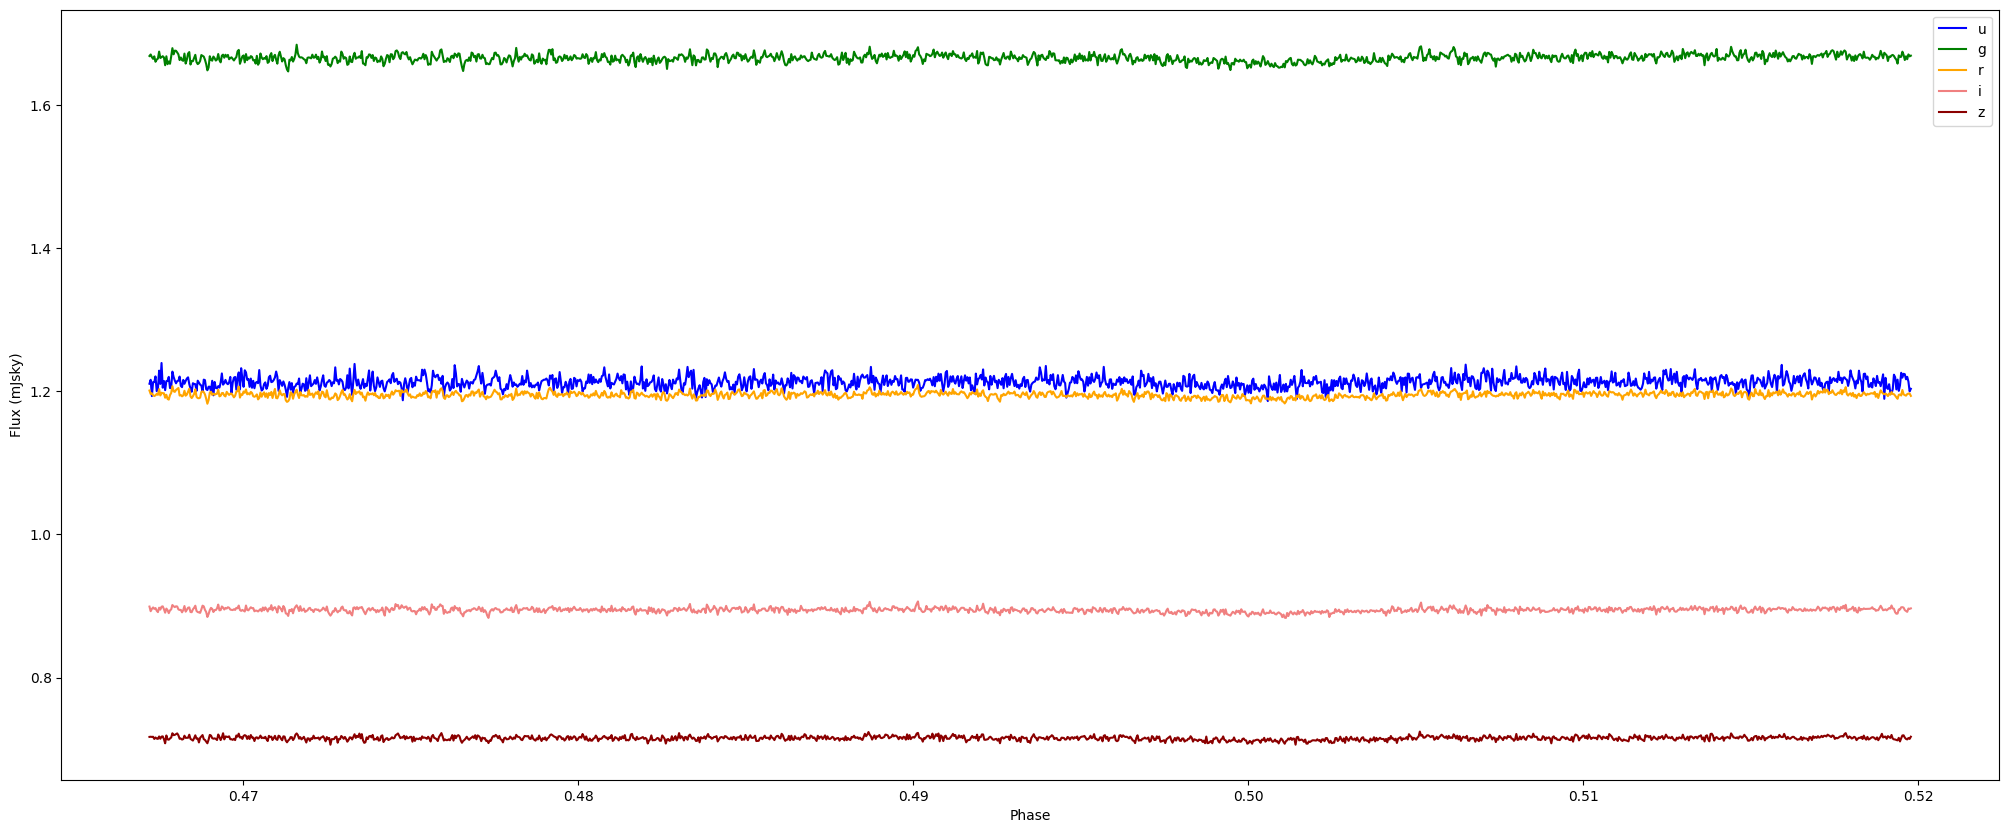

In [22]:
#plotting the flux calibrated lightcurves
bands = ['u', 'g', 'r', 'i', 'z']
colours = ['b', 'g', 'orange', 'lightcoral', 'darkred']

fig, ax = plt.subplots(figsize=(25, 10))

# Plot each band with its corresponding color and label
ax.plot(phase_u, cal_flux_u * 100, color=colours[0], label=bands[0])
ax.plot(phase_u, cal_flux_g * 100, color=colours[1], label=bands[1])
##ax.scatter(phase_u,cal_flux_u*100, color ='red')
#ax.plot(phase_u , diffFluxErr * 100)
ax.plot(phase_u, cal_flux_r * 100, color=colours[2], label=bands[2])
ax.plot(phase_u, cal_flux_i * 100, color=colours[3], label=bands[3])
ax.plot(phase_u, cal_flux_z * 100, color=colours[4], label=bands[4])

#ax.plot(phase_u,ratio_u , color=colours[0], label=bands[0])
#ax.plot(phase_u, fcal_g / fcaltot_g , color=colours[1], label=bands[1])
#ax.scatter(phase_u,cal_flux_u*100, color ='red')
#ax.plot(phase_u , diffFluxErr * 100)
#ax.plot(phase_u, fcal_r / fcaltot_r, color=colours[2], label=bands[2])
#ax.plot(phase_u, fcal_i / fcaltot_i , color=colours[3], label=bands[3])
#ax.plot(phase_u, fcal_z / fcaltot_z , color=colours[4], label=bands[4])

# Add labels and formatting
ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')

# Add a legend to distinguish the lines
ax.legend()

plt.show()

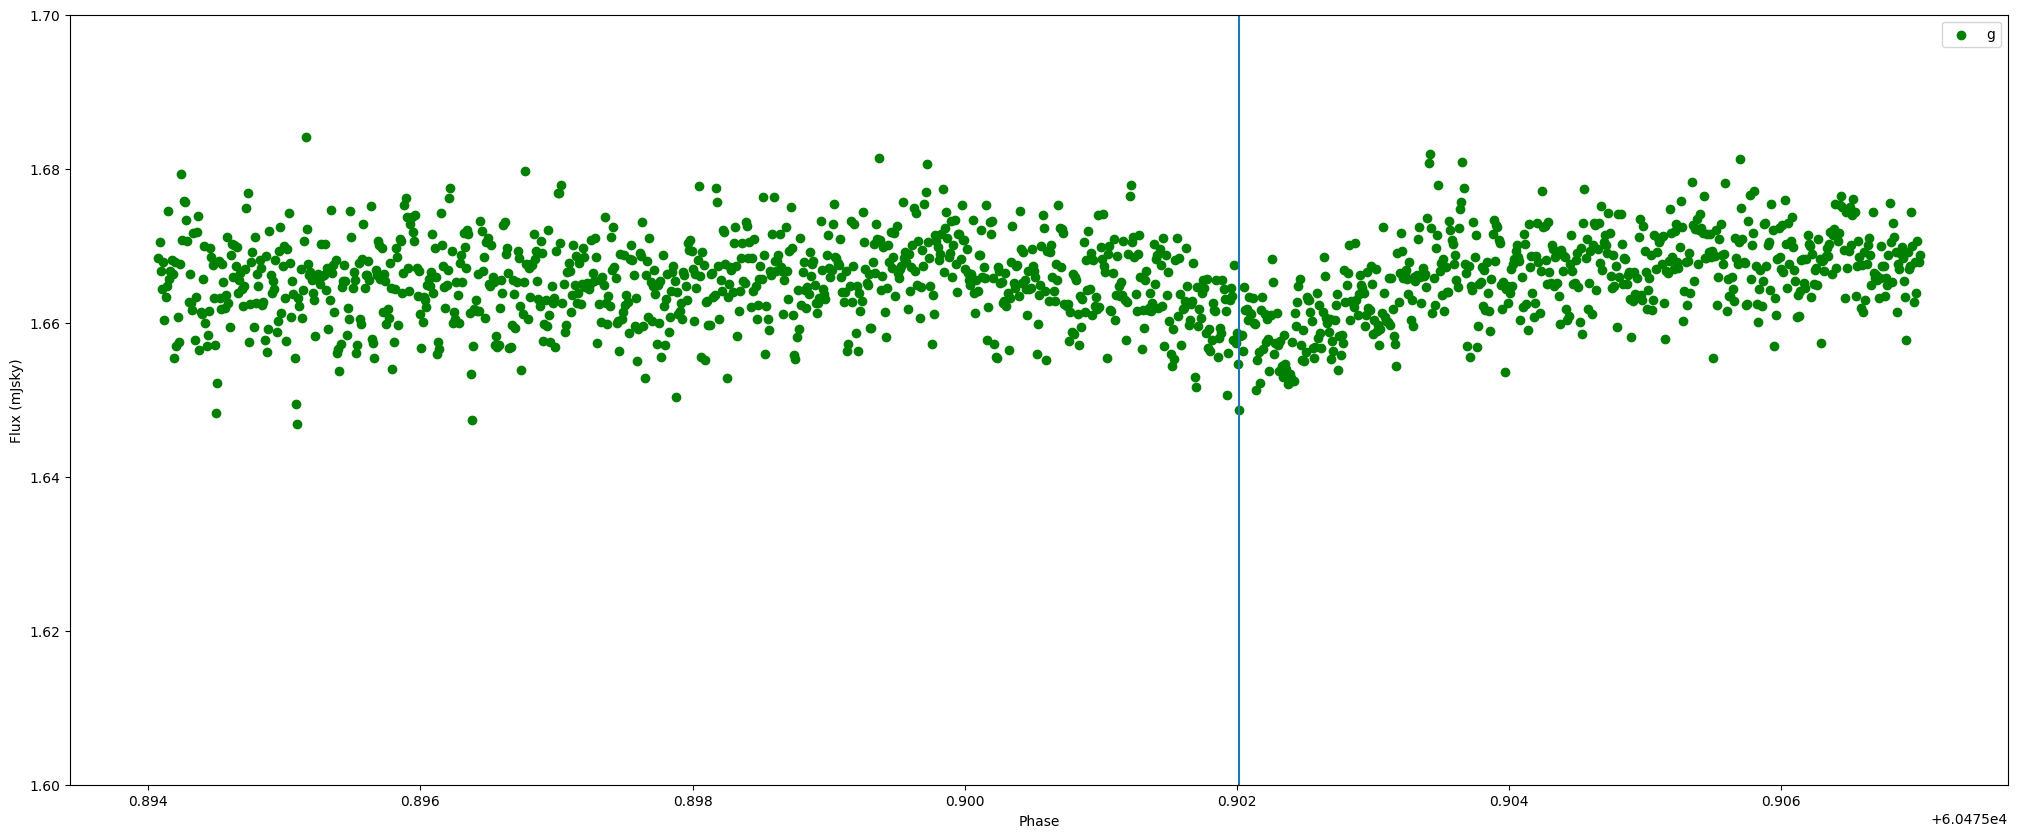

60475.90201697565


In [23]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(baryobs_g_t,cal_flux_g*100, color=colours[1], label=bands[1])
ax.vlines(baryobs_g_t[896],0,100)
ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
ax.set_ylim(1.60,1.70)
# Add a legend to distinguish the lines
ax.legend()

plt.show()
print(baryobs_g_t[896])


In [24]:
w_factors = np.repeat(1,len(obstime_u_t))



g_mid = np.array(sci_g.t)
g_te = np.array(sci_g.te)

r_mid = np.array(sci_r.t)
r_te = np.array(sci_r.te)

i_mid = np.array(sci_i.t)
i_te = np.array(sci_i.te)

z_mid = np.array(sci_z.t)
z_te = np.array(sci_z.te)

In [25]:
#going to column stack data for the eventual lcurve data file

#normal_g = (cal_flux_g - np.min(cal_flux_g)) / (np.max(cal_flux_g) - np.min(cal_flux_g))

sci_flux_u_err = np.array(diffFluxErr_u)
sci_flux_g_err = np.array(diffFluxErr_g)
sci_flux_r_err = np.array(diffFluxErr_r)
sci_flux_i_err = np.array(diffFluxErr_i)
sci_flux_z_err = np.array(diffFluxErr_z)



cal_flux_u = np.array(cal_flux_u)
cal_flux_g = np.array(cal_flux_g)
cal_flux_r = np.array(cal_flux_r)
cal_flux_i = np.array(cal_flux_i)
cal_flux_z = np.array(cal_flux_z)

w_factors = np.array(w_factors)

col_u = np.column_stack((u_mid, u_te, cal_flux_u, sci_flux_u_err, w_factors, w_factors))
col_g = np.column_stack((g_mid, g_te, cal_flux_g, sci_flux_g_err, w_factors, w_factors))
col_r = np.column_stack((r_mid, r_te, cal_flux_r, sci_flux_r_err, w_factors, w_factors))
col_i = np.column_stack((i_mid, i_te, cal_flux_i, sci_flux_i_err, w_factors, w_factors))
col_z = np.column_stack((z_mid, z_te, cal_flux_z, sci_flux_z_err, w_factors, w_factors))




np.savetxt(r'/home/pha19jgb/LCURVE/2024_06_14/U/u_norm.txt',col_u)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_06_14/G/g_norm.txt',col_g)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_06_14/R/r_norm.txt',col_r)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_06_14/I/i_norm.txt',col_i)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_06_14/Z/z_norm.txt',col_z)


In [26]:
#u_tO = 60431.227660469
g_tO = 60475.901620319331 
r_tO = 60475.901632492438 
i_tO = 60475.90156122639
z_tO = 60431.2276239701

#u_err =0.000088457279
g_err =3.4797152e-05
r_err =3.5249606e-05
i_err =3.6633538e-05
z_err =0.000031202113


#u_w = 1/u_err**2
g_w =  1/g_err**2
r_w =  1/r_err**2
i_w =  1/i_err**2
z_w = 1/z_err**2




invmean = ( (g_tO * g_w) + (r_tO * r_w) + (i_tO * i_w)) /( g_w +r_w + i_w)
invmean_err = np.sqrt(1 / ( g_w +r_w + i_w ))
cycle_number = (invmean - reference_epoch) / period

In [27]:
print(invmean)
print(invmean_err)
print(cycle_number)

60475.901605909195
2.051600080273196e-05
19641.497800296285


In [28]:

def eclipse_clip(x,y,z,a,b,upper,lower):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    a = np.array(a)
    # Find the indices where x is within the specified range
    indices = (x >= lower) & (x <= upper)
    
    # Clip the x and y arrays using the indices
    x_clipped = x[indices]
    y_clipped = y[indices]
    z_clipped = z[indices]
    a_clipped = a[indices]
    b_clipped = b[indices]
    w_clip = np.ones_like(x_clipped)
    
    return x_clipped, y_clipped, z_clipped, a_clipped, w_clip, b_clipped
    
u_phase_clip , u_flux_clip, u_flux_err_clip , u_mid_clip,w_clip,u_te_clip = eclipse_clip(phase_u,cal_flux_u,sci_flux_u_err, u_mid,u_te, 0.525,0.475)
g_phase_clip , g_flux_clip, g_flux_err_clip , g_mid_clip,w_clip,g_te_clip = eclipse_clip(phase_u,cal_flux_g,sci_flux_g_err, g_mid,g_te,0.525,0.475)
r_phase_clip , r_flux_clip, r_flux_err_clip , r_mid_clip,w_clip,r_te_clip = eclipse_clip(phase_u,cal_flux_r,sci_flux_r_err, r_mid,r_te, 0.525,0.475)
i_phase_clip , i_flux_clip, i_flux_err_clip , i_mid_clip,w_clip,i_te_clip = eclipse_clip(phase_u,cal_flux_i,sci_flux_i_err, i_mid,i_te, 0.525,0.475)
z_phase_clip , z_flux_clip, z_flux_err_clip , z_mid_clip,w_clip ,z_te_clip= eclipse_clip(phase_u,cal_flux_z,sci_flux_z_err, z_mid,z_te, 0.525,0.475)

In [29]:
def weighted_mean(y, y_err):
    weights = 1 / y_err**2
    return np.sum(y * weights) / np.sum(weights)

u_w_mean = weighted_mean(u_flux_clip,u_flux_err_clip)
g_w_mean = weighted_mean(g_flux_clip,g_flux_err_clip)
r_w_mean = weighted_mean(r_flux_clip,r_flux_err_clip)
i_w_mean = weighted_mean(i_flux_clip,i_flux_err_clip)
z_w_mean = weighted_mean(z_flux_clip,z_flux_err_clip)
print('resc_u_0430 =',u_w_mean)
print('resc_g_0430 =',g_w_mean)
print("resc_r_0430 =",r_w_mean)
print("resc_i_0430 =",i_w_mean)
print("resc_z_0430 =",z_w_mean)



resc_u_0430 = 0.01212602
resc_g_0430 = 0.016656432
resc_r_0430 = 0.011949184
resc_i_0430 = 0.008941772
resc_z_0430 = 0.007152346


In [30]:
#rescale to the means from vennes
resc_u_0430 = 0.015128573944642197
resc_g_0430 = 0.017745389550558835
resc_r_0430 = 0.013876951938054634
resc_i_0430 = 0.01104802703671854
resc_z_0430 = 0.008153518016431193


u_flux_resc_clip = u_flux_clip + (resc_u_0430 - u_w_mean)
g_flux_resc_clip = g_flux_clip + (resc_g_0430 - g_w_mean)
r_flux_resc_clip = r_flux_clip + (resc_r_0430 - r_w_mean)
i_flux_resc_clip = i_flux_clip + (resc_i_0430 - i_w_mean)
z_flux_resc_clip = z_flux_clip + (resc_z_0430 - z_w_mean)

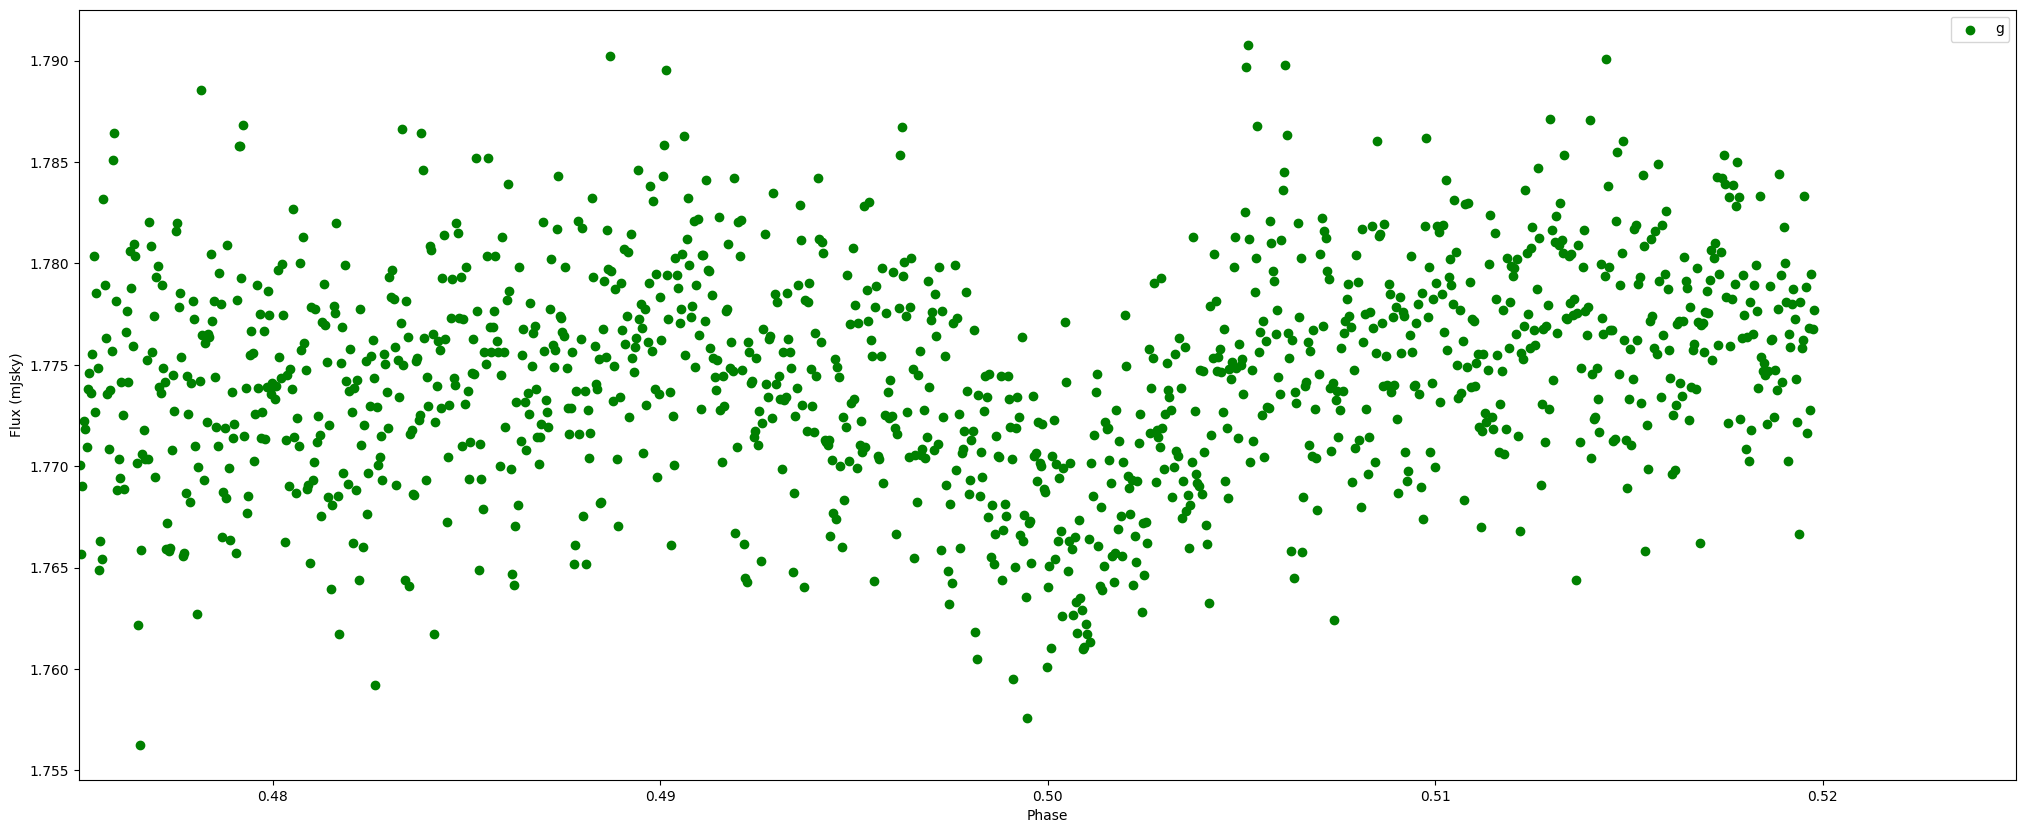

In [31]:
fig, ax = plt.subplots(figsize=(25, 10))

ax.scatter(g_phase_clip,g_flux_resc_clip*100, color=colours[1], label=bands[1])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(1.6,1.75)
ax.set_xlim(0.475,0.525)
ax.legend()

plt.show()

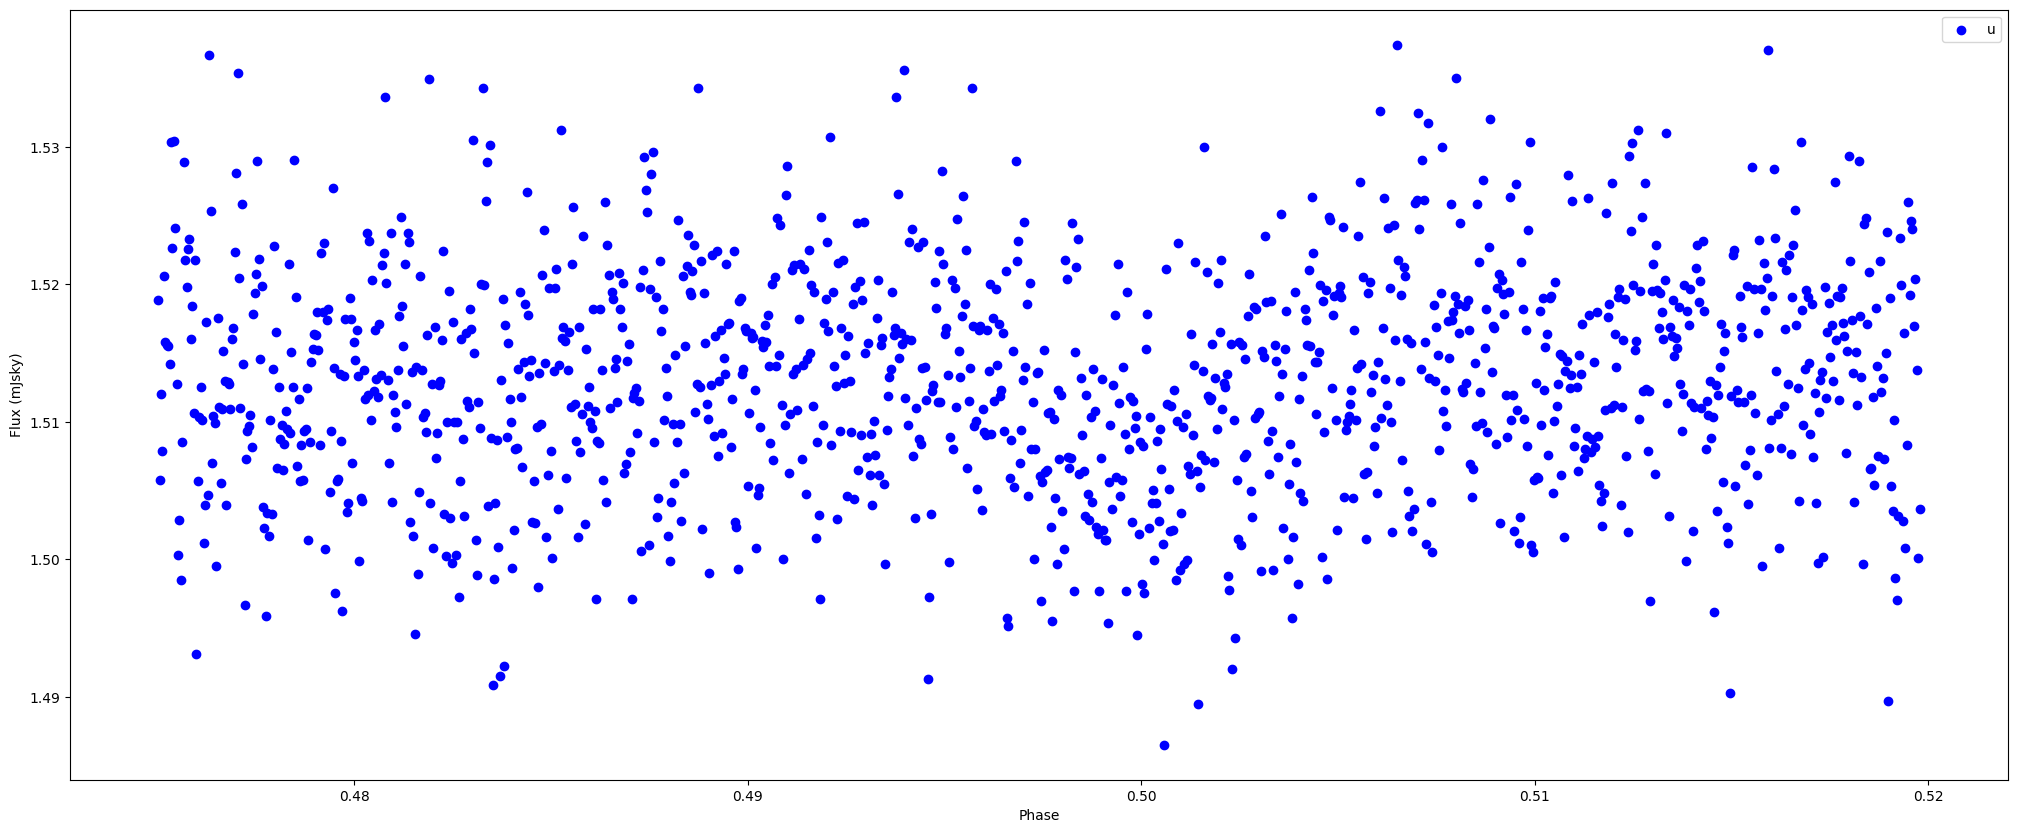

In [32]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(u_phase_clip,u_flux_resc_clip*100, color=colours[0], label=bands[0])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(1.20,1.45)
# Add a legend to distinguish the lines
ax.legend()

plt.show()

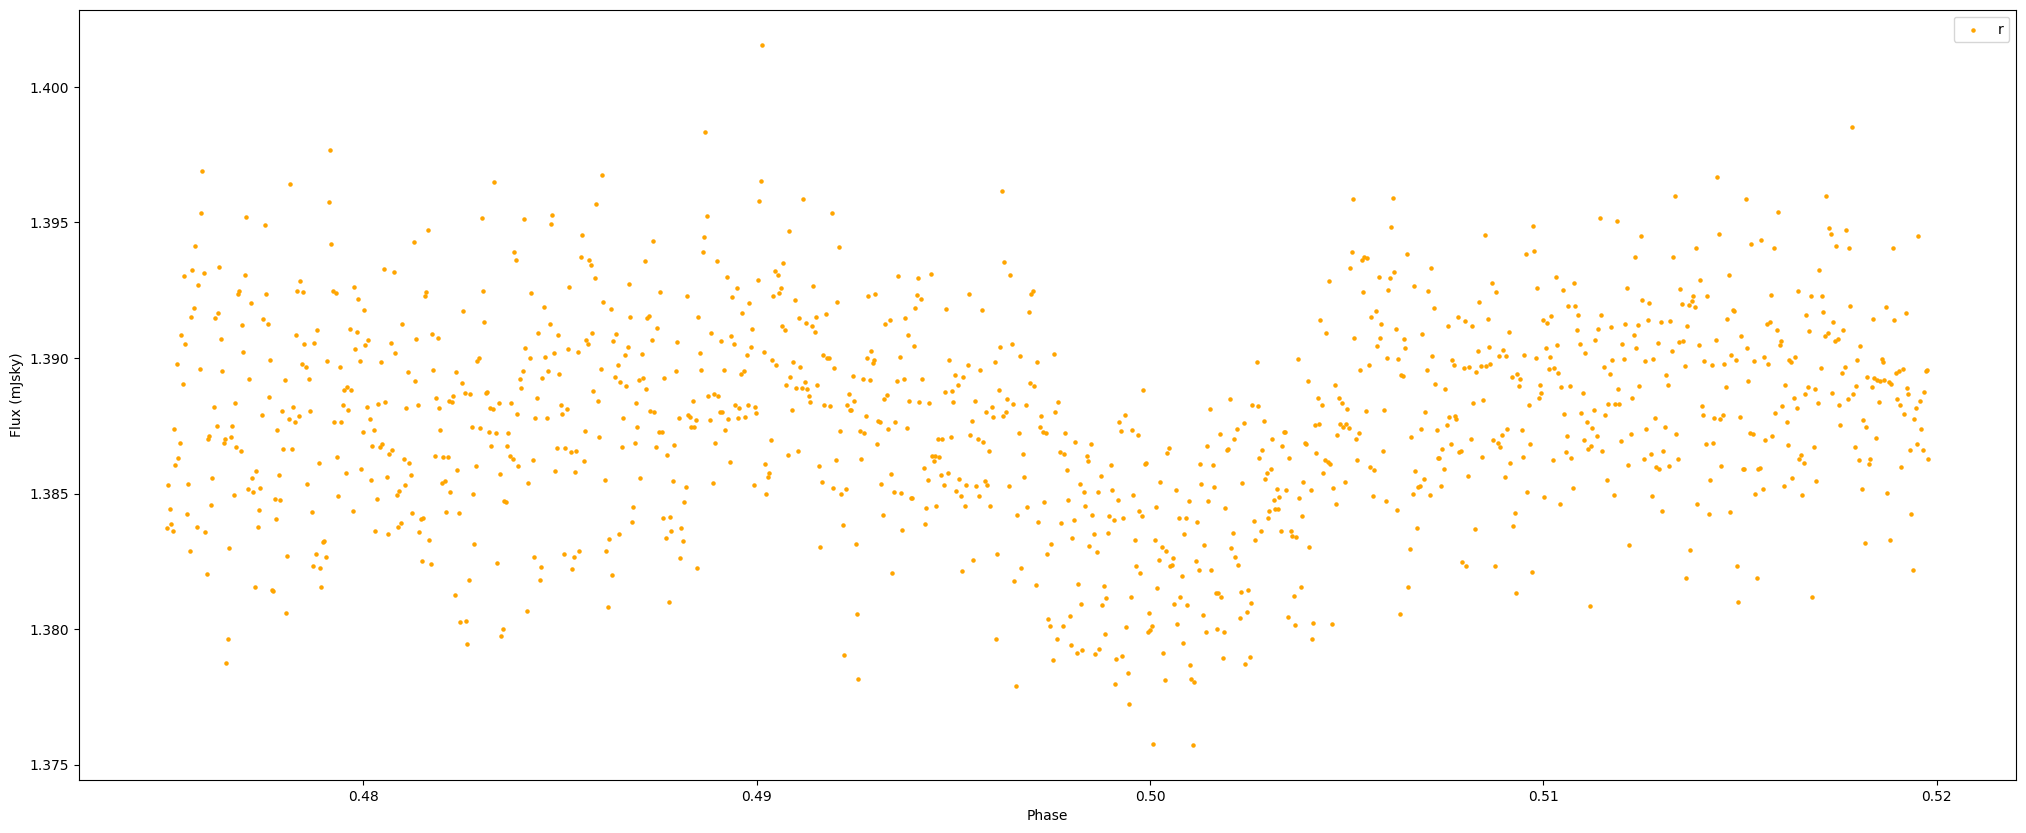

In [33]:
fig, ax = plt.subplots(figsize=(25, 10))

ax.scatter(r_phase_clip,r_flux_resc_clip*100, color=colours[2], label=bands[2], s=5)

ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(1.05,1.25)

ax.legend()

plt.show()

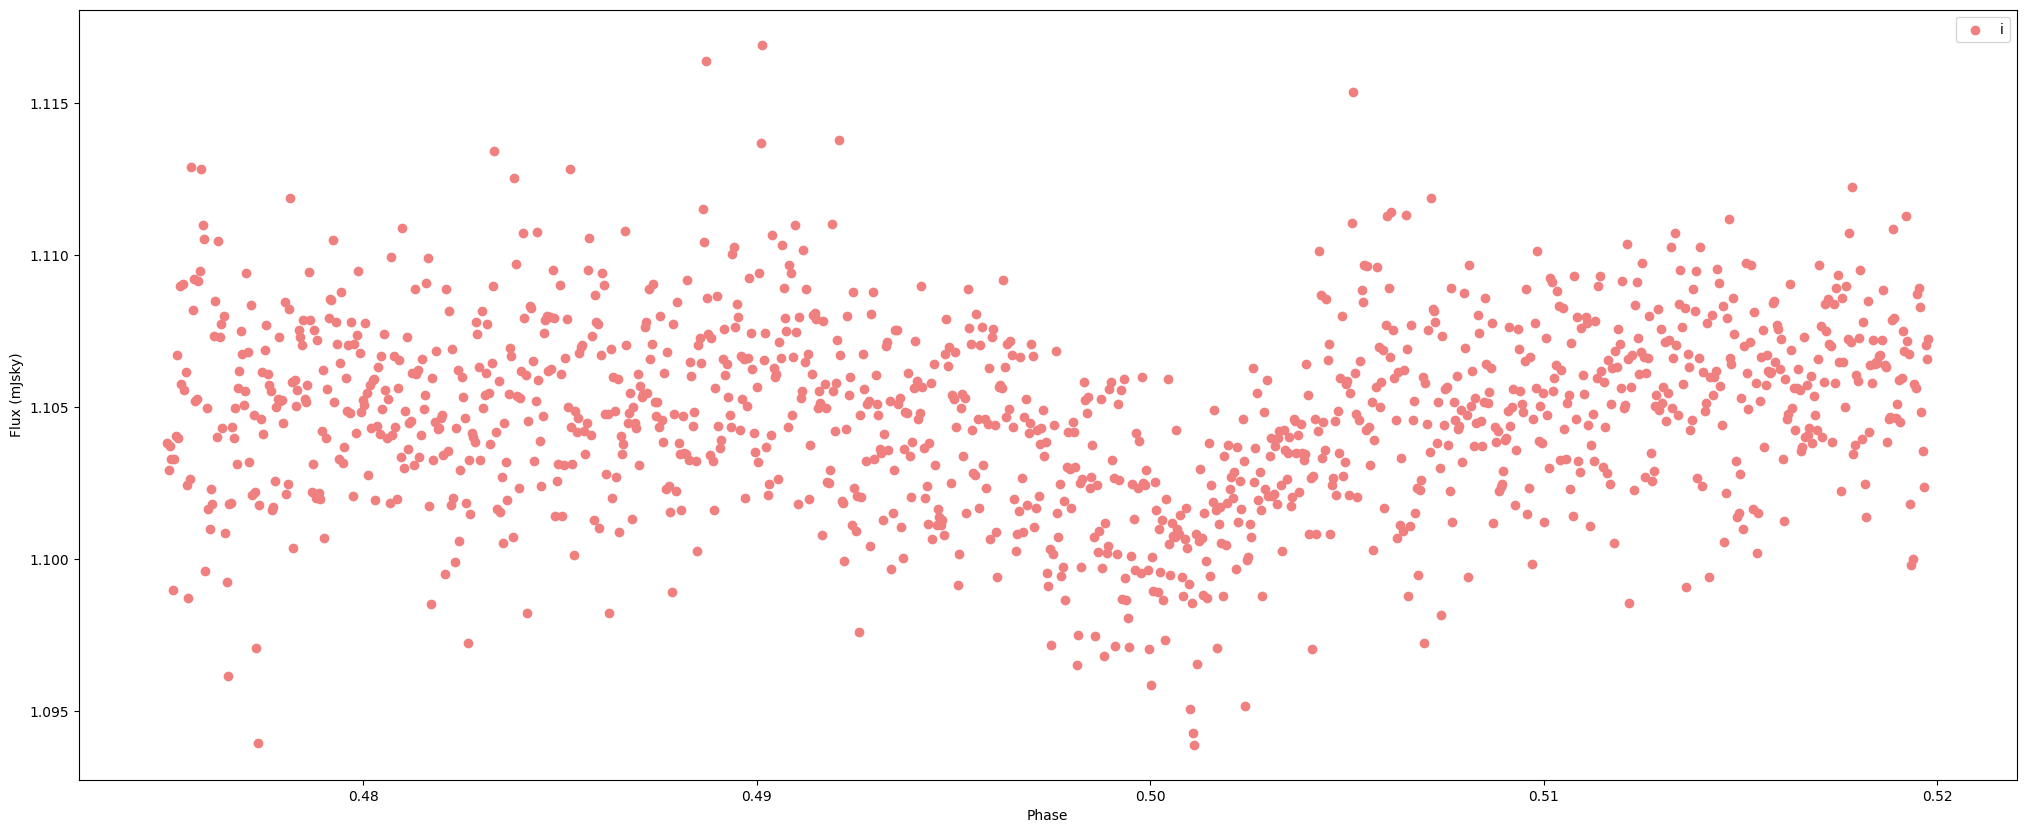

In [34]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(i_phase_clip,i_flux_resc_clip*100, color=colours[3], label=bands[3])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(0.85,0.95)

ax.legend()

plt.show()

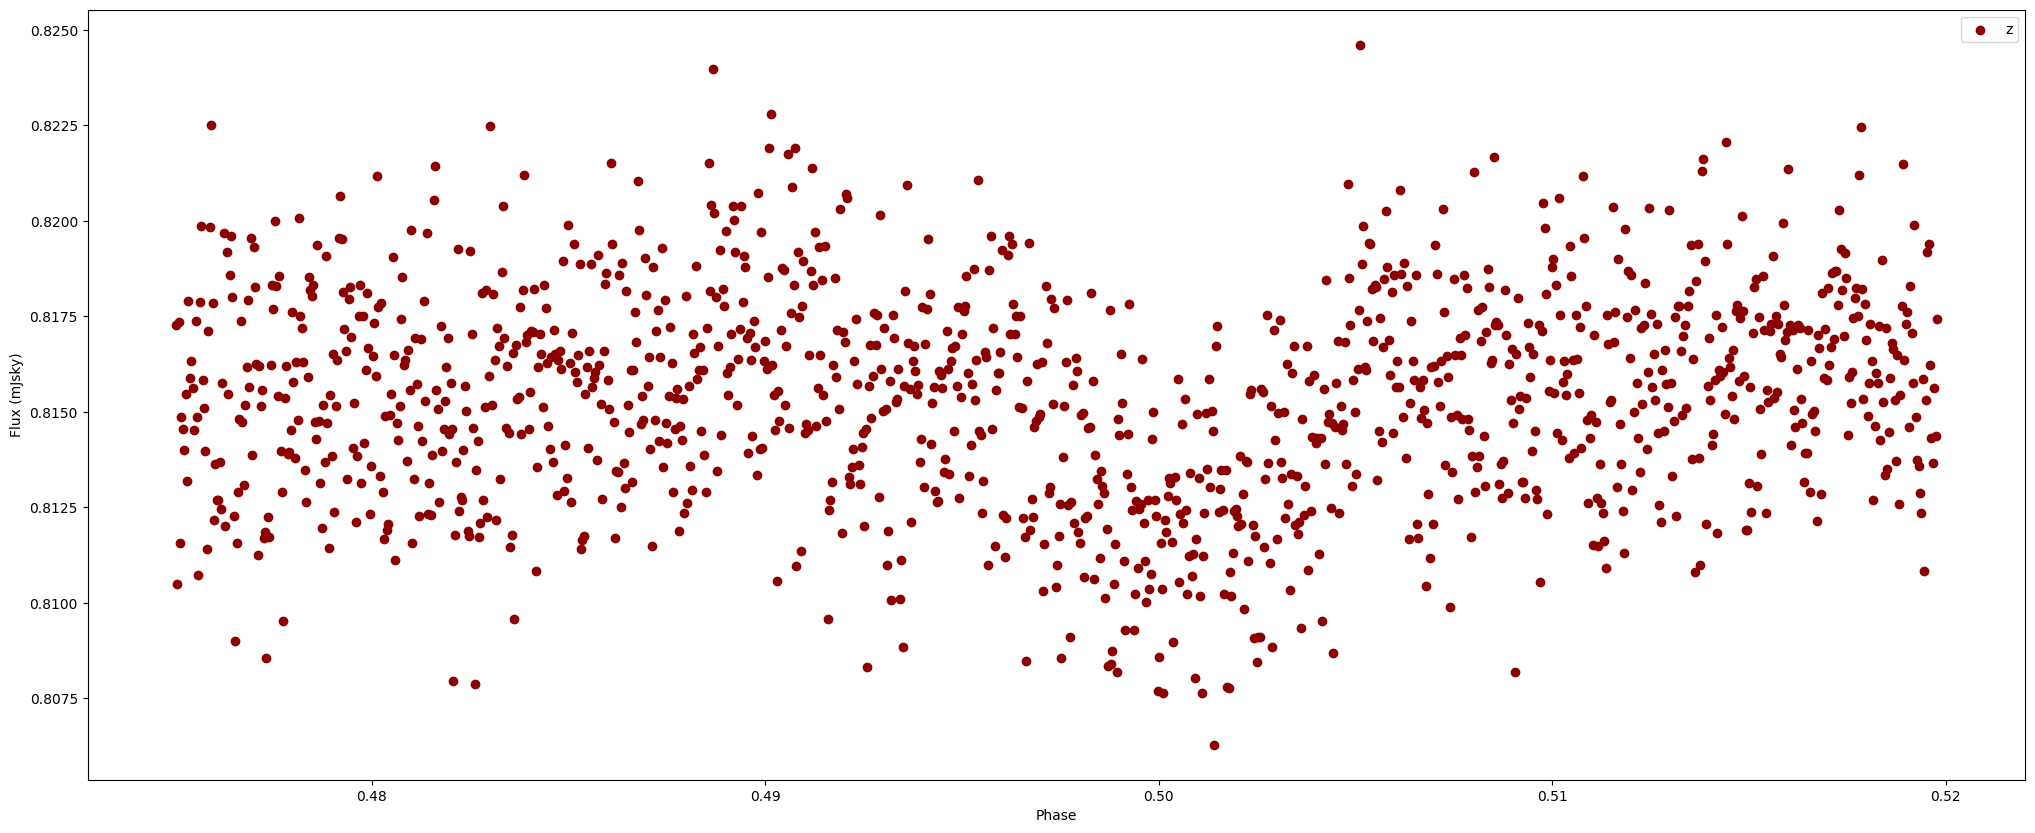

In [35]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(z_phase_clip,z_flux_resc_clip*100, color=colours[4], label=bands[4])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(0.68,0.75)
# Add a legend to distinguish the lines
ax.legend()

plt.show()

In [36]:
col_u_clip = np.column_stack((u_phase_clip,u_te_clip, u_flux_clip, u_flux_err_clip, w_clip, w_clip))
col_g_clip = np.column_stack((g_phase_clip,g_te_clip, g_flux_clip, g_flux_err_clip, w_clip, w_clip))
col_r_clip = np.column_stack((r_phase_clip,r_te_clip, r_flux_clip, r_flux_err_clip, w_clip, w_clip))
col_i_clip = np.column_stack((i_phase_clip,i_te_clip, i_flux_clip, i_flux_err_clip, w_clip, w_clip))
col_z_clip = np.column_stack((z_phase_clip,z_te_clip, z_flux_clip, z_flux_err_clip, w_clip, w_clip))


In [37]:
print(col_u,col_u_clip)

[[6.04758934e+04 8.77374259e-06 1.21048186e-02 7.26221188e-05
  1.00000000e+00 1.00000000e+00]
 [6.04758934e+04 8.77374259e-06 1.21600479e-02 7.22374243e-05
  1.00000000e+00 1.00000000e+00]
 [6.04758934e+04 8.77374259e-06 1.19322129e-02 7.05782659e-05
  1.00000000e+00 1.00000000e+00]
 ...
 [6.04759063e+04 8.77374259e-06 1.21348966e-02 6.93910915e-05
  1.00000000e+00 1.00000000e+00]
 [6.04759063e+04 8.77374259e-06 1.19981514e-02 6.85149353e-05
  1.00000000e+00 1.00000000e+00]
 [6.04759063e+04 8.77374259e-06 1.20337084e-02 6.82505051e-05
  1.00000000e+00 1.00000000e+00]] [[4.75016960e-01 8.77374259e-06 1.21859973e-02 7.28881641e-05
  1.00000000e+00 1.00000000e+00]
 [4.75052974e-01 8.77374259e-06 1.20551400e-02 7.02227917e-05
  1.00000000e+00 1.00000000e+00]
 [4.75088988e-01 8.77374259e-06 1.21178841e-02 7.17664370e-05
  1.00000000e+00 1.00000000e+00]
 ...
 [5.19710176e-01 8.77374259e-06 1.21348966e-02 6.93910915e-05
  1.00000000e+00 1.00000000e+00]
 [5.19746190e-01 8.77374259e-06 1.19981

def eclipse_clip(x,y,z,a,b,upper,lower):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    a = np.array(a)
    # Find the indices where x is within the specified range
    indices = (x >= lower) & (x <= upper)
    
    # Clip the x and y arrays using the indices
    x_clipped = x[indices]
    y_clipped = y[indices]
    z_clipped = z[indices]
    a_clipped = a[indices]
    b_clipped = b[indices]
    w_clip = np.ones_like(x_clipped)
    
    return x_clipped, y_clipped, z_clipped, a_clipped, w_clip, b_clipped
    
u_phase_clip , u_flux_clip, u_flux_err_clip , u_mid_clip,w_clip,u_te_clip = eclipse_clip(phase_u,cal_flux_u,sci_flux_u_err, u_mid,u_te, 0.525,0.475)
g_phase_clip , g_flux_clip, g_flux_err_clip , g_mid_clip,w_clip,g_te_clip = eclipse_clip(phase_u,cal_flux_g,sci_flux_g_err, g_mid,g_te, 0.525,0.475)
r_phase_clip , r_flux_clip, r_flux_err_clip , r_mid_clip,w_clip,r_te_clip = eclipse_clip(phase_u,cal_flux_r,sci_flux_r_err, r_mid,r_te, 0.525,0.475)
i_phase_clip , i_flux_clip, i_flux_err_clip , i_mid_clip,w_clip,i_te_clip = eclipse_clip(phase_u,cal_flux_i,sci_flux_i_err, i_mid,i_te, 0.525,0.475)
z_phase_clip , z_flux_clip, z_flux_err_clip , z_mid_clip,w_clip,z_te_clip = eclipse_clip(phase_u,cal_flux_z,sci_flux_z_err, z_mid,z_te, 0.525,0.475)

In [38]:
col_u_clip = np.column_stack((u_mid_clip, u_te_clip, u_flux_clip, u_flux_err_clip, w_clip, w_clip))
col_g_clip = np.column_stack((g_mid_clip, g_te_clip, g_flux_clip, g_flux_err_clip, w_clip, w_clip))
col_r_clip = np.column_stack((r_mid_clip, r_te_clip, r_flux_clip, r_flux_err_clip, w_clip, w_clip))
col_i_clip = np.column_stack((i_mid_clip, i_te_clip, i_flux_clip, i_flux_err_clip, w_clip, w_clip))
col_z_clip = np.column_stack((z_mid_clip, z_te_clip, z_flux_clip, z_flux_err_clip, w_clip, w_clip))

np.savetxt(r'/home/pha19jgb/LCURVE/udat0614.txt',col_u_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/gdat0614.txt',col_g_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/rdat0614.txt',col_r_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/idat0614.txt',col_i_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/zdat0614.txt',col_z_clip)

In [39]:
#u_te to new "Phase" units
u_te_ph = u_te_clip / period
g_te_ph = g_te_clip / period
r_te_ph = r_te_clip / period
i_te_ph = i_te_clip / period
z_te_ph = z_te_clip / period
print(u_te_ph)

[3.564602e-05 3.564602e-05 3.564602e-05 ... 3.564602e-05 3.564602e-05
 3.564602e-05]


In [40]:
ph_col_u_clip = np.column_stack((u_phase_clip, u_te_ph, u_flux_resc_clip, u_flux_err_clip, w_clip, w_clip))
ph_col_g_clip = np.column_stack((g_phase_clip, g_te_ph, g_flux_resc_clip, g_flux_err_clip, w_clip, w_clip))
ph_col_r_clip = np.column_stack((r_phase_clip, r_te_ph, r_flux_resc_clip, r_flux_err_clip, w_clip, w_clip))
ph_col_i_clip = np.column_stack((i_phase_clip, i_te_ph, i_flux_resc_clip, i_flux_err_clip, w_clip, w_clip))
ph_col_z_clip = np.column_stack((z_phase_clip, z_te_ph, z_flux_resc_clip, z_flux_err_clip, w_clip, w_clip))

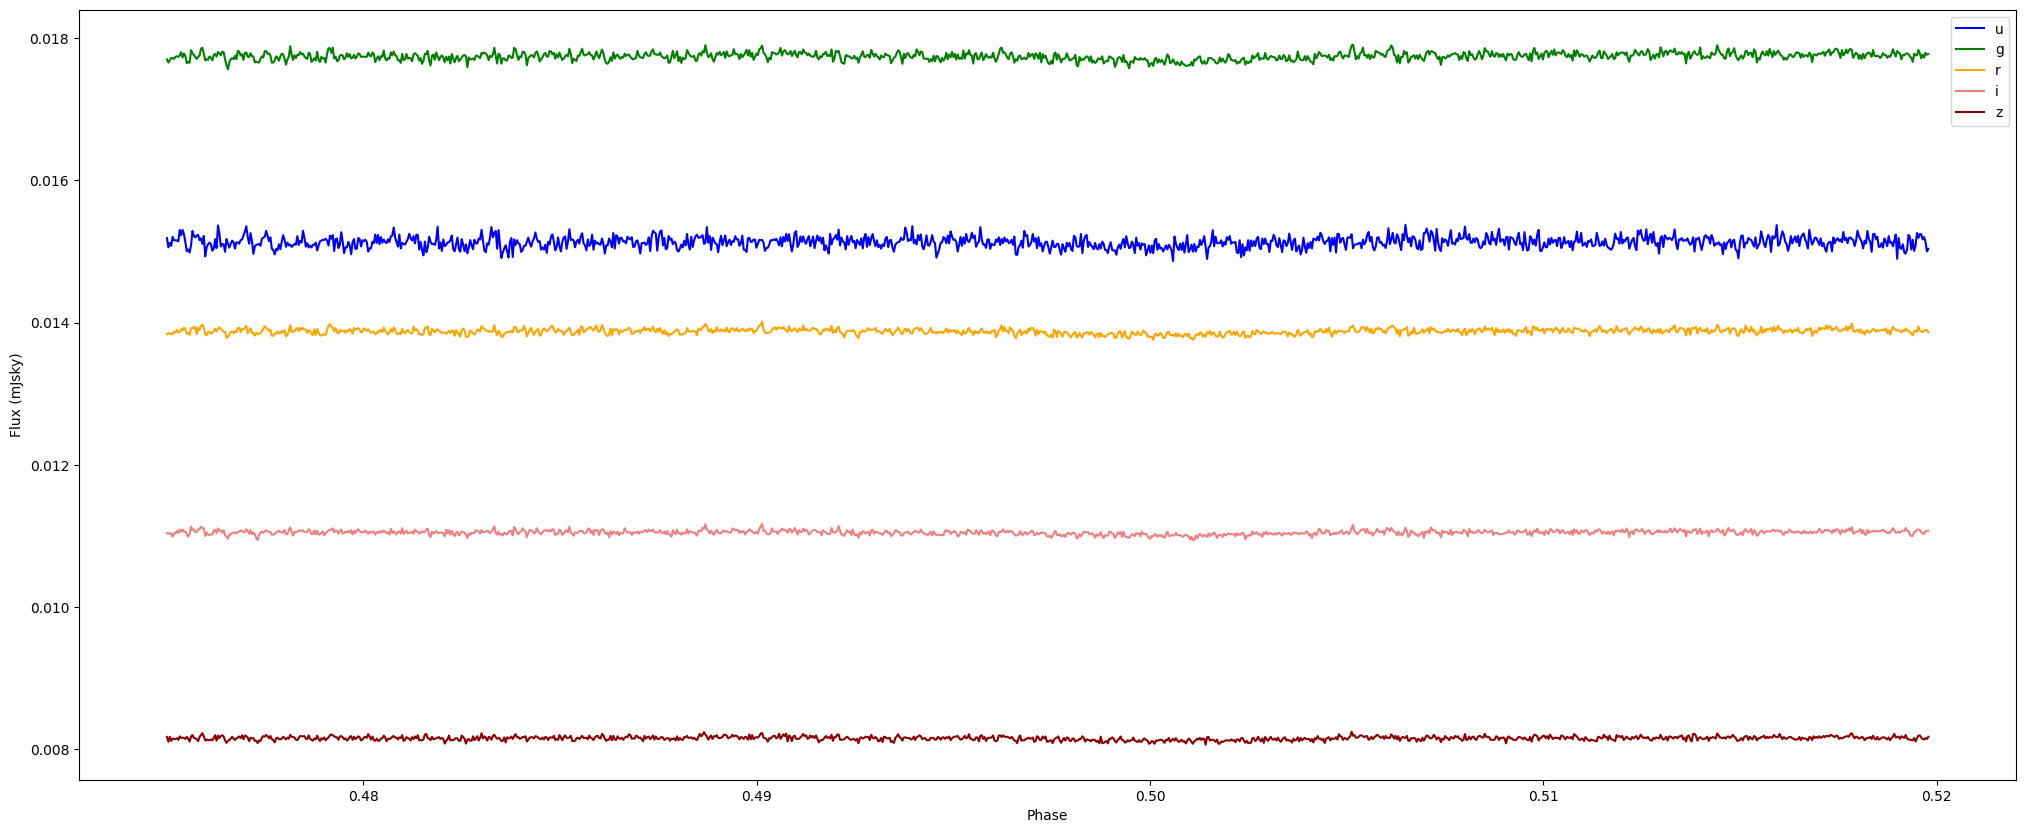

In [41]:
#plotting the flux calibrated lightcurves
bands = ['u', 'g', 'r', 'i', 'z']
colours = ['b', 'g', 'orange', 'lightcoral', 'darkred']

fig, ax = plt.subplots(figsize=(25, 10))

# Plot each band with its corresponding color and label
ax.plot(u_phase_clip,u_flux_resc_clip, color=colours[0], label=bands[0])
ax.plot(g_phase_clip, g_flux_resc_clip , color=colours[1], label=bands[1])
ax.plot(r_phase_clip, r_flux_resc_clip , color=colours[2], label=bands[2])
ax.plot(i_phase_clip, i_flux_resc_clip , color=colours[3], label=bands[3])
ax.plot(z_phase_clip, z_flux_resc_clip , color=colours[4], label=bands[4])



# Add labels and formatting
ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')

# Add a legend to distinguish the lines
ax.legend()

plt.show()

In [42]:
np.savetxt(r'/home/pha19jgb/LCURVE/ph_udat0614.txt',ph_col_u_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/ph_gdat0614.txt',ph_col_g_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/ph_rdat0614.txt',ph_col_r_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/ph_idat0614.txt',ph_col_i_clip)
np.savetxt(r'/home/pha19jgb/LCURVE/ph_zdat0614.txt',ph_col_z_clip)